In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
plt.rc('pdf', fonttype=42)

from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

BIG    = 22
MEDIUM = 20
FIGWIDTH= 12
WIDTH = 0.25  # the width of the bars
NARROW=0.2

XLINE  = 523.21
YLINE  = 0.002

colors = ['#E27100', '#1b85b8', '#559e83', '#b26167']

# Starting to define standardized colors
MAE_COLOR =colors[1]
TIME_COLOR=colors[0]

In [46]:
# Combining V100 and P100 on same row for same run
# We are deleting cases where there is no run for either of the architectures
# Every column name is appended with the name of the architecture (e.g. "_V100");
# This includes the `master_index` (e.g `master_index_V100`)

df_joined = pd.read_parquet('../df_master_joined.parquet')
df_joined.master_index_P100 = df_joined.master_index_P100.astype('int64') # Make sure index is integer
df_joined.master_index_V100 = df_joined.master_index_V100.astype('int64') # Make sure index is integer
df_joined.shape


# This is an "empty" dataframe (meaning no rows), containing
# column names for numerical data only.
# The column nmaes can be used to index the columns of the
# scaled data (in master_scaled_data.npy)

df_columns_only = pd.read_parquet('../df_column_reference.parquet')


# This is a 2-D numpy array corresponding to the numerical data in 'df_master.parquet'
# The data has been scaled using the StandardScaler in scikitlearn

# Notes: 
#   - The row indices correspond to the `master_index` column of 'df_master.parquet'
#   - The columns correspond to the columns in 'df_column_reference.parquet'.
#     (e.g. can use `df.get_loc(column-name)` to get the column index)

master_data_scaled = np.load('../master_scaled_data.npy')
master_data_scaled.shape

(78330, 116)

In [47]:
#temp_col = df_joined['dram_write_throughput_P100'] + df_joined['dram_read_throughput_P100']
#df_joined= df_joined[temp_col>5e9]

temp_col = df_joined['dram_write_throughput_P100']
temp_col2 = df_joined['dram_read_throughput_P100']
temp_col4 = df_joined['dram_write_throughput_V100']
temp_col5 = df_joined['dram_read_throughput_V100']
df_joined =df_joined[temp_col>1e9]
df_joined =df_joined[temp_col2>1e9]
df_joined =df_joined[temp_col4>1e9]
df_joined =df_joined[temp_col5>1e9]

/Users/yzamora/miniconda3/envs/python_work/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/Users/yzamora/miniconda3/envs/python_work/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
/Users/yzamora/miniconda3/envs/python_work/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()


In [48]:
df = df_joined.copy()  # Start with all of df_joined

# Target index and values (values are NOT in master_data_scaled)
target_index = df['master_index_V100'].values
target = df['memory_bound_V100'].values

# Training data index and values (values ARE in master_data_scaled)
data_index = df['master_index_P100'].values
data = master_data_scaled[ data_index ]

# Need to drop 'dram_read_throughput' and 'dram_write_throughput'
indices = []
for i, col in enumerate(df_columns_only.columns):
    if col not in ['dram_read_throughput', 'dram_write_throughput','dram_write_transactions','dram_read_transactions']:
    #if col not in not_import:
        indices.append(i)       
data = data[:,indices]
data.shape

(18396, 112)

## Baseline

In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = y_true + 0.000000001
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Mean Absolute Error: 0.0
Mean Absolute Percentage Error: 53.36346694164141
R2 Score -0.3633520858237984


Text(0.5,1,'Baseline Memory Throughput - MAE: 0.0')

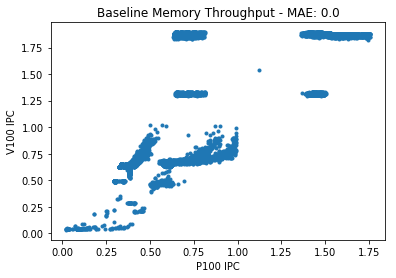

In [50]:
V100_ipc = (df_joined['ipc_V100']).values
P100_ipc = (df_joined['ipc_P100']).values
plt.plot(V100_ipc, P100_ipc,'.')
plt.xlabel('P100 IPC')
plt.ylabel('V100 IPC')
errors = abs(V100_ipc - P100_ipc)/1024/1024/1024
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(V100_ipc,P100_ipc))
print("R2 Score", r2_score(V100_ipc,P100_ipc))
plt.title('Baseline Memory Throughput - MAE: ' + str(mean_error))

In [51]:
df_target = (df_joined['ipc_V100']).values
# Split the data for training
(
    X_train, X_test,
    y_train, y_test,
    #data_index_train, data_index_test,
    #target_index_train, target_index_test
) = train_test_split(
    data,
    df_target,
    #data_index,
    #target_index,
    random_state=42,
    test_size=.33
)

In [52]:
clf = RandomForestRegressor(n_jobs=2, n_estimators=200, max_depth=100)
reg_model = clf.fit(X_train, y_train)

In [53]:
y_test_predict = clf.predict(X_test)

Mean Absolute Error: 0.22
Mean Absolute Percentage Error: 29.98017081955623
R2 Score 0.5476668336400283


Text(0.5,1,'Baseline Memory Throughput - MAE: 0.22')

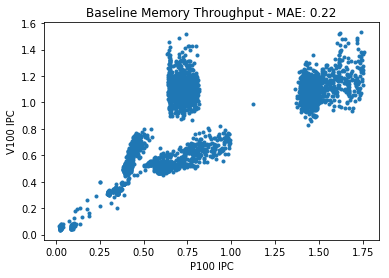

In [54]:
plt.plot(y_test, y_test_predict,'.')
plt.xlabel('P100 IPC')
plt.ylabel('V100 IPC')
errors = abs(y_test - y_test_predict)
mean_error = round(np.mean(errors),2)
print('Mean Absolute Error:', round(np.mean(errors),2))
print('Mean Absolute Percentage Error:',mean_absolute_percentage_error(y_test, y_test_predict))
print("R2 Score", r2_score(y_test, y_test_predict))
plt.title('Baseline Memory Throughput - MAE: ' + str(mean_error))

In [41]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators=1000, max_depth=150, eta=0.1, subsample=0.7, colsample_bytree=0.8)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["rmse", "mae"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:0.41166	validation_0-mae:0.27230	validation_1-rmse:0.43688	validation_1-mae:0.28830
[1]	validation_0-rmse:0.37961	validation_0-mae:0.24920	validation_1-rmse:0.41426	validation_1-mae:0.26882
[2]	validation_0-rmse:0.35019	validation_0-mae:0.22829	validation_1-rmse:0.39380	validation_1-mae:0.25295
[3]	validation_0-rmse:0.32350	validation_0-mae:0.20951	validation_1-rmse:0.37605	validation_1-mae:0.24120
[4]	validation_0-rmse:0.29896	validation_0-mae:0.19256	validation_1-rmse:0.36087	validation_1-mae:0.23283
[5]	validation_0-rmse:0.27657	validation_0-mae:0.17728	validation_1-rmse:0.34821	validation_1-mae:0.22685
[6]	validation_0-rmse:0.25643	validation_0-mae:0.16359	validation_1-rmse:0.33696	validation_1-mae:0.22209
[7]	validation_0-rmse:0.23766	validation_0-mae:0.15111	validation_1-rmse:0.32756	validation_1-mae:0.21883
[8]	validation_0-rmse:0.22063	validation_0-mae:0.13999	validation_1-rmse:0.31906	validation_1-mae:0.21616
[9]	validation_0-rmse:0.20456	validation_0-mae

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=150,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [42]:
y_test_predict = model.predict(X_test)
errors = abs(y_test_predict - y_test)/1024/1024/1024
mean_error = round(np.mean(errors),2)

R2 Score 0.5435795311263043


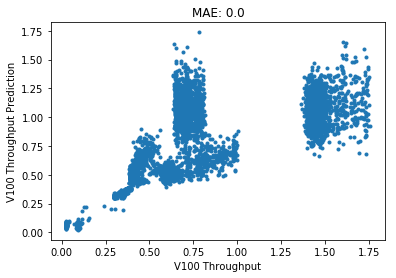

In [43]:
plt.plot(y_test, y_test_predict,'.')
plt.xlabel('V100 Throughput')
plt.ylabel('V100 Throughput Prediction')
plt.title('MAE: ' + str(mean_error))
print("R2 Score", r2_score(y_test,y_test_predict))

In [44]:
print("Mean absolute percentage error:",mean_absolute_percentage_error(y_test,y_test_predict))

Mean absolute percentage error: 26.876556330934886
